In [1]:
%matplotlib notebook

In [2]:
import xemc3
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
sys.path.append('/u/phg/adas')
from importlib import reload
import atomdat.adas.ibal_phg as ibal; reload(ibal)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, pyplot as plt

# xemc3 load

In [7]:
philip_folder =  "/u/phg/adas/atomdatpy"
experiment_folder = "x-exp_NR"
experiment_folder = "N03.00_P05.00_D05_C04.50-TEST"
"N03.00_P05.00_D05_C02.50-TEST"

'N03.00_P05.00_D05_C02.50-TEST'

In [8]:
ds = xr.open_dataset(f"{philip_folder}/{experiment_folder}.nc")

In [9]:
relevant = ["ne", "Te", *(f"nZ{i}" for i in range(1,14))]

In [10]:
ne, te = np.array(ds["ne"]), np.array(ds["Te"])

# L_z voxel load

In [15]:
#lz = np.load("testing_lz.npy")
#lz_steps = np.load(f"{experiment_folder}_testing_lz.npy")
lz_tot = np.load(f"{experiment_folder}_testing_lz.npy")

In [16]:
lz_tot.shape

(139, 512, 36)

# Binning (in $n_e$, $t_e$ parameter space)

In [21]:
# L_z depends on n_e as well as T_e. 
# All three of these quantities are given for every voxel of the grid, but plotting them all would chrash everthing
# [We could flatten all of the arrays because we don't care about the coordinates for now, but let's not for now]
# So we bin n_e and t_e into some (logarithmic) bins.
# for any bin pair, we can get all L_z, n_e and t_e values in the bin combination by ANDing the bin masks
# [if we apply the mask on a meshgrid, we can also keep track of the r,tht,phi indices]
# with those flattened L_z_tot, n_e, t_e, r, tht, phi arrays we can for example MEAN & STD everything and plot a 
# 2d L_z_tot(n_e, t_e) plot with one vertex per bin instead of per voxel

In [22]:
r_grid, tht_grid, phi_grid = np.indices(ne.shape) # np.mgrid[[slice(None, i) for i in ne.shape]]

In [23]:
te_res, ne_res = 100, 100
# *1.01 so that the max value is still inside the last bin. NAN will be outside and can therefore be ignored
te_bins = np.logspace(start=np.log(np.nanmin(te)), stop=np.log(np.nanmax(te)*1.01), num=te_res+1, base=np.e)
ne_bins = np.logspace(start=np.log(np.nanmin(ne)), stop=np.log(np.nanmax(ne)*1.01), num=ne_res+1, base=np.e)
ne_mask = np.digitize(ne, ne_bins)
te_mask = np.digitize(te, te_bins)

In [24]:
# [te][ne][L_z mean and std, te mean and std, ne mean and std, number of elements]
bin_data = np.empty((te_res, ne_res, 7), dtype="float64")
bin_data.fill(np.nan)  # fill with nans by default 

for ite in range(te_res):
    for ine in range(ne_res):
        if ite%2 and ine==0: print(ite, end="\t")
        
        # bin 0 is skipped/empty, bin xe_res exists
        bin_mask = (te_mask == ite+1) & (ne_mask == ine+1)
        
        num_entries = np.argwhere(bin_mask).shape[0]
        bin_data[ite,ine,6] = num_entries
        if num_entries == 0:
            # but at least put placeholder values in the te, ne mean values
            bin_data[ite,ine,2] = np.mean(te_bins[ite:ite+2])
            bin_data[ite,ine,4] = np.mean(ne_bins[ine:ine+2])
            continue

        # possibly do something with coordinates
        # r_grid[bin_mask], tht_grid[bin_mask], phi_grid[bin_mask]
        bin_data[ite,ine,0] = lz_tot[bin_mask].mean()
        bin_data[ite,ine,1] = lz_tot[bin_mask].std()
        bin_data[ite,ine,2] = te[bin_mask].mean()
        bin_data[ite,ine,3] = te[bin_mask].std()
        bin_data[ite,ine,4] = ne[bin_mask].mean()
        bin_data[ite,ine,5] = ne[bin_mask].std()

1	3	5	7	9	11	13	15	17	19	21	23	25	27	29	31	33	35	37	39	41	43	45	47	49	51	53	55	57	59	61	63	65	67	69	71	73	75	77	79	81	83	85	87	89	91	93	95	97	99	

# Plotting (in $n_e$, $t_e$ parameter space)

In [25]:
d = bin_data.transpose(2,0,1)
X, Y, Z = np.log10(d[2]), np.log10(d[4]), np.log10(d[6])

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


<IPython.core.display.Javascript object>


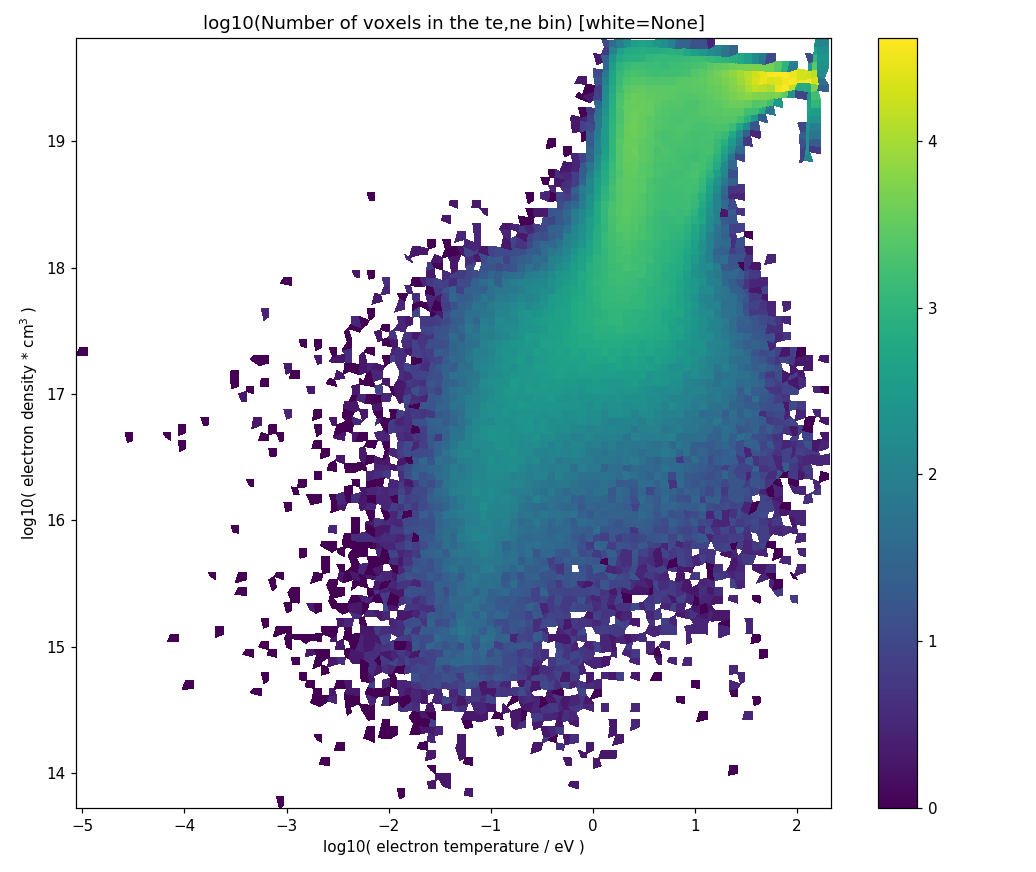

In [26]:
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,8))
c = ax.pcolormesh(X, Y, Z)
ax.set_xlabel("log10( electron temperature / eV )")
ax.set_ylabel("log10( electron density * cm$^3$ )")
ax.set_title("log10(Number of voxels in the te,ne bin) [white=None]")
fig.colorbar(c)
# ax.set_aspect("equal")
fig.tight_layout()

<IPython.core.display.Javascript object>


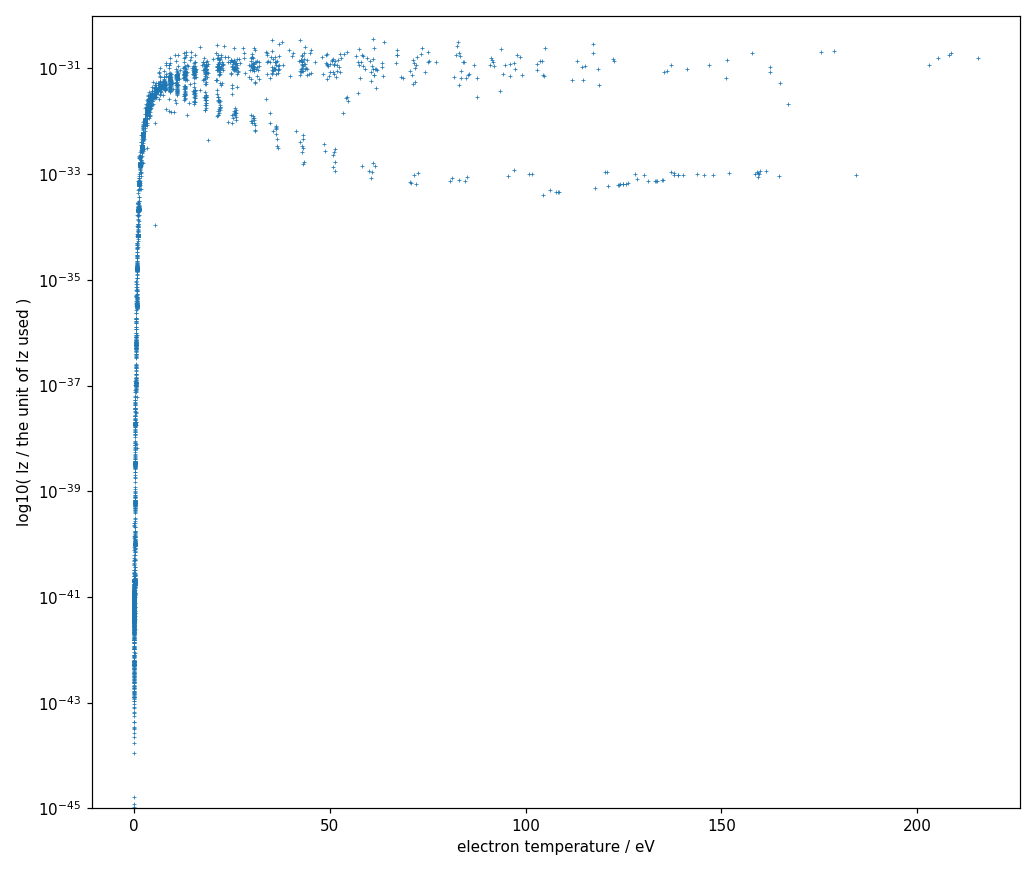

In [29]:
# scatter all bin values on lz(te) plot:
pl_te, pl_lz = d[2].flatten(), d[0].flatten()

plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,8))

ax.scatter(pl_te, pl_lz, s=10, marker="+", lw=0.5)

ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("log10( lz / the unit of lz used )")
ax.set_ylim(1e-45, 1e-30)
ax.set_yscale("log")
fig.tight_layout()

# Binning (in $r$, $\theta$, $\phi$ parameter space)

In [65]:
def rebin(arr, shrink_factors):
    arr = arr.copy()
    new_start_shape = tuple(fac*(size//fac) for size, fac in zip(arr.shape, shrink_factors))
    arr = arr[tuple(slice(None,i) for i in new_start_shape)]
    
    subshape = []
    for dim in range(len(new_start_shape)):
        subshape.append(new_start_shape[dim]//shrink_factors[dim])
        subshape.append(shrink_factors[dim])
    subshape = tuple(subshape)
    
    arr = arr.reshape(subshape)
    
    for dim in range(len(new_start_shape)):
        arr = np.nanmean(arr, axis=-1-dim)
        # arr = arr.mean(axis=-1-dim)
        # arr = arr.mean(axis=-1-dim) is want to sum
        
    return arr

In [82]:
shrink = (1, 1, 1) # (4,4,2) # (16,32,3) # (139, 512, 36) -> (23, 32, 12)
skip = tuple(slice(None,None,i) for i in (1,1,1))  # (1,2,36)

te_small = rebin(te, shrink)[skip]
ne_small = rebin(ne, shrink)[skip]
lz_tot_small = rebin(lz_tot, shrink)[skip]

/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


# Plotting (in $r$, $\theta$, $\phi$ parameter space)

<IPython.core.display.Javascript object>


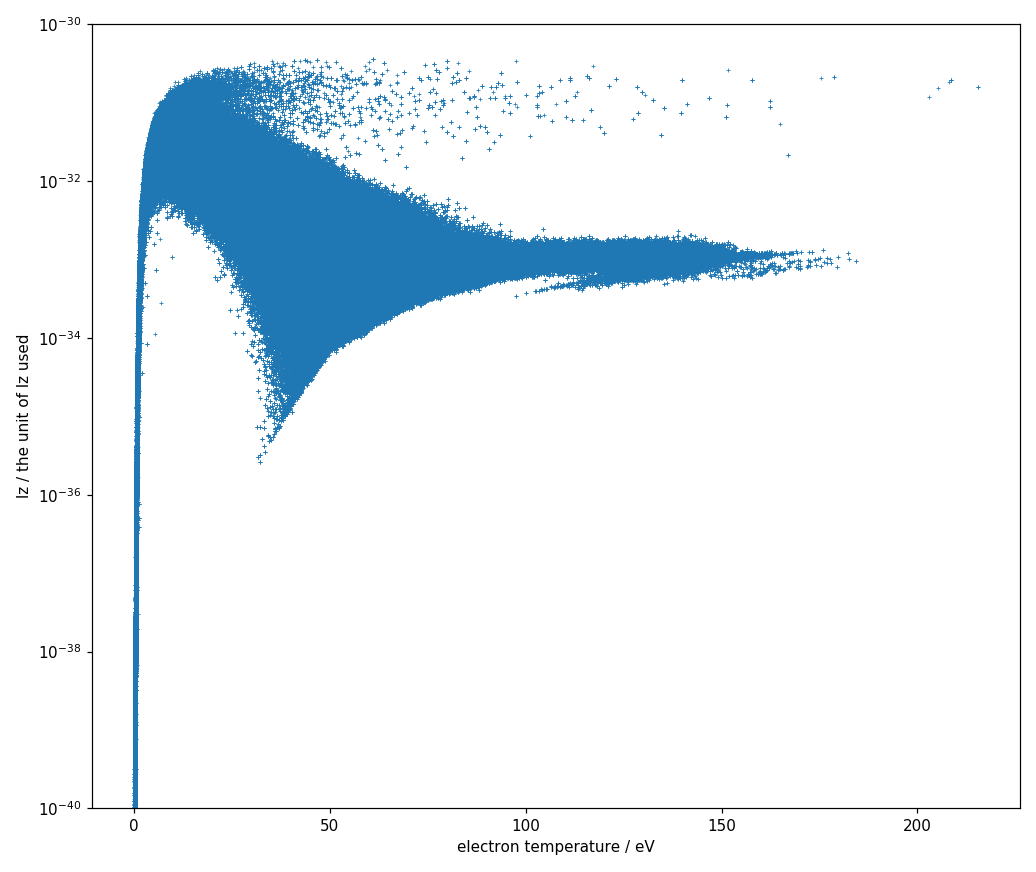

In [83]:
# scatter all bin values on lz(te) plot:

pl_te, pl_lz = te_small.flatten(), lz_tot_small.flatten()

plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,8))

ax.scatter(pl_te, pl_lz, s=10, marker="+", lw=0.5)

ax.set_xlabel("electron temperature / eV")
ax.set_ylabel("lz / the unit of lz used")
ax.set_ylim(1e-40, 1e-30)
ax.set_yscale("log")
fig.tight_layout()

In [58]:
plt.close("all")
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(9.5,9.5))
ax.scatter(np.log10(te_small.flatten()), 
           np.log10(ne_small.flatten()), 
           np.log10(lz_tot_small.flatten()))

ax.set_xlabel("log10( electron temperature / eV )")
ax.set_ylabel("log10( electron density * cm$^3$ )")
ax.set_zlabel("$L_Z$ / Wm$^3$")

ax.set_xlim(-0.5,2.5)
ax.set_ylim(14.5,20.5)
ax.set_zlim(-35,-31.5)

fig.tight_layout()

<IPython.core.display.Javascript object>

# Comparison with calculated lz

<IPython.core.display.Javascript object>


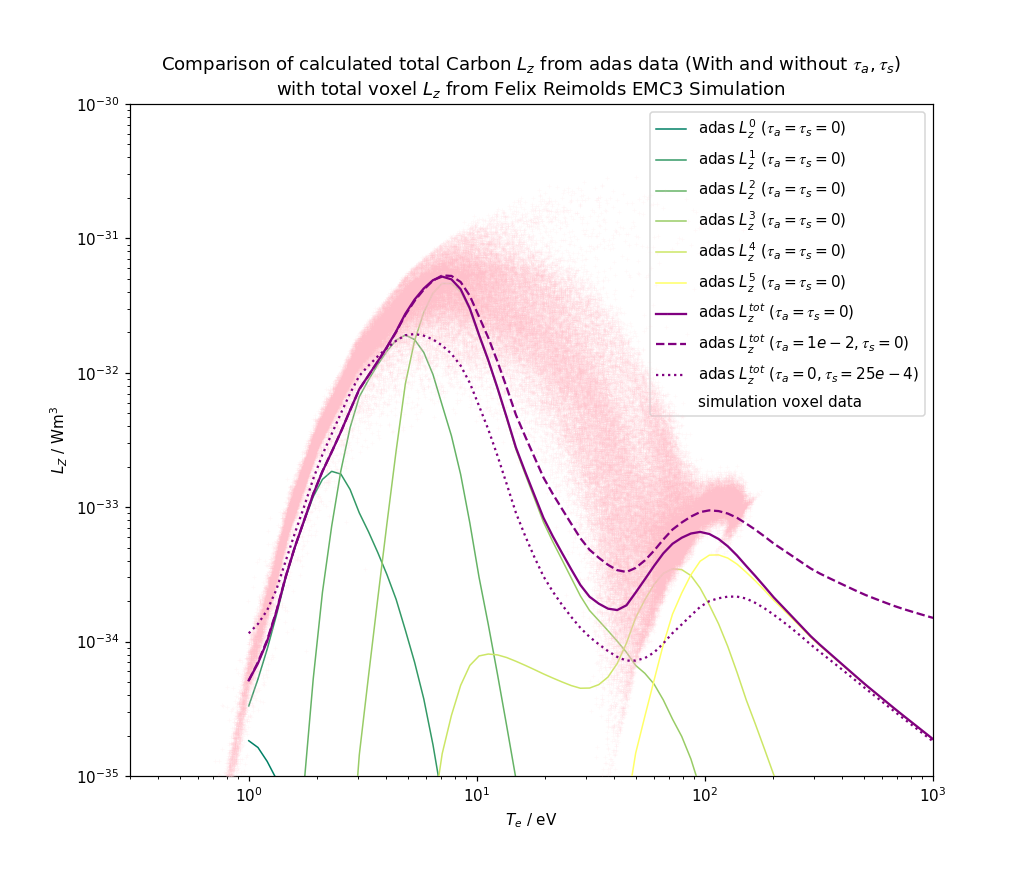

In [69]:
xte = np.logspace(0.,4.,100)
xne = 1e20
_,_,lz, _ = ibal.calc_fz('c', te=xte, ne=xne, taua=0.)
_,_,lzt1,_ = ibal.calc_fz('c', te=xte, ne=xne, taua=0.01)
_,_,lzt2,_ = ibal.calc_fz('c', te=xte, ne=xne, taus=0.0025)
*lz, lges = lz.T
*lzt1, lgest1 = lzt1.T
*lzt2, lgest2 = lzt2.T


colors = cm.get_cmap("summer", len(lz))(np.linspace(0.0, 1.0, len(lz)))
plt.close("all")
fig, ax = plt.subplots(figsize=(9.5,8))

for i, li in enumerate(lz):
    ax.plot(xte, li, c=colors[i], linestyle="-", lw=1, zorder=i,
            label=f"adas $L_z^{i}$ ($𝜏_a=𝜏_s=0$)")
# for i, li in enumerate(lzt1):
#     ax.plot(xte, li, c=colors[i], linestyle="--", lw=0.5)
# for i, li in enumerate(lzt2):
#     ax.plot(xte, li, c=colors[i], linestyle=":", lw=0.5)

ax.plot(xte, lges, c="purple", label="adas $L_z^{tot}$ ($𝜏_a=𝜏_s=0$)", linestyle="-", zorder=100)
ax.plot(xte, lgest1, c="purple", linestyle="--", zorder=100,
       label="adas $L_z^{tot}$ ($𝜏_a=1e-2, 𝜏_s=0$)")
ax.plot(xte, lgest2, c="purple", linestyle=":", zorder=100,
       label="adas $L_z^{tot}$ ($𝜏_a=0, 𝜏_s=25e-4$)")

ax.scatter(pl_te, pl_lz, s=10, marker="+", lw=0.5, c="pink", label="simulation voxel data", zorder=50,
          alpha=.1)
#ax.scatter(pl_te, pl_lz*3.0, s=10, marker="+", lw=0.5, c="orange", label="data")
    
    
ax.set_xlabel("$T_e$ / eV")
ax.set_ylabel("$L_Z$ / Wm$^3$")
ax.set_yscale("log"); ax.set_xscale("log")
ax.set_xlim(0.3,1000); ax.set_ylim(1e-35, 1e-30)
ax.legend()

ax.set_title("Comparison of calculated total Carbon $L_z$ from adas data (With and without $𝜏_a, 𝜏_s$)\n\
with total voxel $L_z$ from Felix Reimolds EMC3 Simulation")
fig.savefig("../images/img1.png", dpi=200)

# ax.set_title("Comparison of calculated total Carbon $L_z$ from adas data (With and without $𝜏_a, 𝜏_s$)\n\
# with total voxel $L_z$ from Victoria Winters EMC3 Simulation")
# fig.savefig("../images/img2.png", dpi=200)